This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# xarray powered plotting

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import wradlib
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()

### Read a polar data set from the German Weather Service

In [2]:
filename = wradlib.util.get_wradlib_data_file('dx/raa00-dx_10908-0806021735-fbg---bin.gz')
print(filename)

/home/kai/python/projects/wradlib-data/dx/raa00-dx_10908-0806021735-fbg---bin.gz


In [3]:
img, meta = wradlib.io.read_dx(filename)

Inspect the data set a little

In [4]:
print("Shape of polar array: %r\n" % (img.shape,))
print("Some meta data of the DX file:")
print("\tdatetime: %r" % (meta["datetime"],))
print("\tRadar ID: %s" % (meta["radarid"],))

Shape of polar array: (360, 128)

Some meta data of the DX file:
	datetime: datetime.datetime(2008, 6, 2, 17, 35, tzinfo=<UTC>)
	Radar ID: 10908


### transform to xarray datarray

In [ ]:
da = wradlib.io.create_xarray_dataarray(img)

### The simplest way to plot this dataset

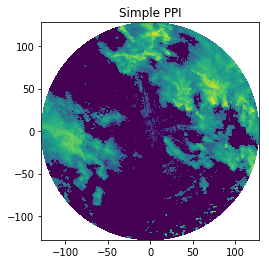

In [ ]:
da.wradlib.plot_ppi()
txt = pl.title('Simple PPI')

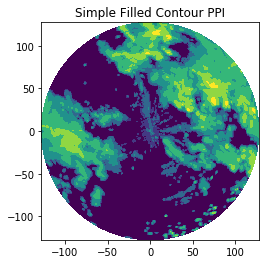

In [ ]:
da.wradlib.contourf()
txt = pl.title('Simple Filled Contour PPI')

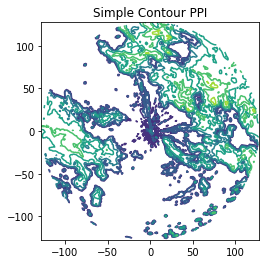

In [ ]:
da.wradlib.contour()
txt = pl.title('Simple Contour PPI')

In [ ]:
da.wradlib.contour(cg=True)
txt = pl.title('Simple CG Contour PPI')
txt.set_y(1.1)

### create dataarray with proper azimuth/range dimensions

In [ ]:
r = np.arange(img.shape[1], dtype=np.float)
r += (r[1] - r[0]) / 2.
r *= 1000
az = np.arange(img.shape[0], dtype=np.float)
az += (az[1] - az[0]) / 2.

da = wradlib.io.create_xarray_dataarray(img, rays=az, bins=r, site=(10, 45, 0))
da.wradlib.pcolormesh()
txt = pl.title('Simple PPI')

In [ ]:
da.wradlib.pcolormesh(rf=1000.)
txt = pl.title('Simple PPI with adjusted range axis')

In [ ]:
da.wradlib.plot_ppi(proj=wradlib.georef.get_default_projection())
txt = pl.title('Simple projected PPI')

### Plotting just one sector

For this purpose, we slice azimuth/range...

In [ ]:
ax, pm = da.sel(time=slice(200,250), 
                range=slice(40000,80000)).wradlib.plot_ppi(rf=1000)
txt = pl.title('Sector PPI')

### Adding a crosshair to the PPI 

In [ ]:
# We introduce a site offset...
site = (10., 45., 0)
da = wradlib.io.create_xarray_dataarray(img, rays=az, bins=r, site=(10, 45, 0))
da.wradlib.plot_ppi()
# ... plot a crosshair over our data...
wradlib.vis.plot_ppi_crosshair(site=site, ranges=[50e3, 100e3, 128e3], 
                               angles=[0, 90, 180, 270], 
                               line=dict(color='white'), 
                               circle={'edgecolor': 'white'})
pl.title('Offset and Custom Crosshair')
pl.axis("tight")
pl.axes().set_aspect('equal')

### Placing the polar data in a projected Cartesian reference system

Using the `proj` keyword we tell the function to:
- interpret the site coordinates as longitude/latitude
- reproject the coordinates to the given projection (here: dwd-radolan composite coordinate system)

In [ ]:
site=(10., 45., 0)
proj_rad = wradlib.georef.create_osr("dwd-radolan")
ax, pm = da.wradlib.plot_ppi(proj=proj_rad)
# Now the crosshair ranges must be given in meters
wradlib.vis.plot_ppi_crosshair(site=site,
                               ax=ax,
                               ranges=[40000, 80000, 128000],
                               line=dict(color='white'),
                               circle={'edgecolor':'white'},
                               proj=proj_rad
                               )
pl.title('Georeferenced/Projected PPI')
pl.axis("tight")
pl.axes().set_aspect('equal')

### Some side effects of georeferencing

Transplanting the radar virtually moves it away from the central meridian of the projection (which is 10 degrees east). Due north now does not point straight upwards on the map.

The crosshair shows this: for the case that the lines should actually become curved, they are implemented as a piecewise linear curve with 10 vertices. The same is true for the range circles, but with more vertices, of course.

In [ ]:
site=(45., 7., 0.)
r = np.arange(img.shape[1], dtype=np.float)
r += (r[1] - r[0]) / 2.
az = np.arange(img.shape[0], dtype=np.float)
az += (az[1] - az[0]) / 2.
da = wradlib.io.create_xarray_dataarray(img, rays=az, bins=r, site=site)
ax, pm = da.wradlib.plot_ppi(proj=proj_rad)
ax = wradlib.vis.plot_ppi_crosshair(site=site,
                               ranges=[64000, 128000],
                               line=dict(color='red'),
                               circle={'edgecolor': 'red'},
                               proj=proj_rad
                               )
txt = pl.title('Projection Side Effects')

### More decorations and annotations

You can annotate these plots by using standard matplotlib methods.

In [ ]:
r = np.arange(img.shape[1], dtype=np.float)
r += (r[1] - r[0]) / 2.
az = np.arange(img.shape[0], dtype=np.float)
az += (az[1] - az[0]) / 2.

da = wradlib.io.create_xarray_dataarray(img, rays=az, bins=r)
ax, pm = da.wradlib.plot_ppi()

ylabel = ax.set_xlabel('easting [km]')
ylabel = ax.set_ylabel('northing [km]')
title = ax.set_title('PPI manipulations/colorbar')
# you can now also zoom - either programmatically or interactively
xlim = ax.set_xlim(-80, -20)
ylim = ax.set_ylim(-80, 0)
# as the function returns the axes- and 'mappable'-objects colorbar needs, adding a colorbar is easy
cb = pl.colorbar(pm, ax=ax)